# PROBLEM SET #3: DIMENSIONAL REDUCTION

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA

### links to sklearn documentation  that may be useful

- <a href=http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html>$\texttt{http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html}$</a>

- <a href=http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html>$\texttt{http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html}$</a>



# Problem 1 (35%)

In the lecture notebook we used a 2-dimensional polynomial kernel to do Kernel PCA on the 3 and 8 digits from the sklearn digits data. As there, we have an initial dimensionality of $D=64$ and want to project down to $d=2$ dimensions.

__(a)__ Use the sklearn KernelPCA module to do Kernel PCA on the 3 and 8s digits. Try both the polynomial and rbf kernels. Plot the results. Notice that the kernels have various hyperparameters like gamma that you can and should play around with.

__(b)__ Calculate Fisher's linear discriminant (with respect to the two classes, '3' and '8') _after_ you've done the projection down to two dimensions. How large of a value of $F({\bf w})$ can you obtain? With what kernel and what kernel hyperparameter settings?

### (a)

poly fisher: 2.20480672426
rbf fisher: 0.261511429376


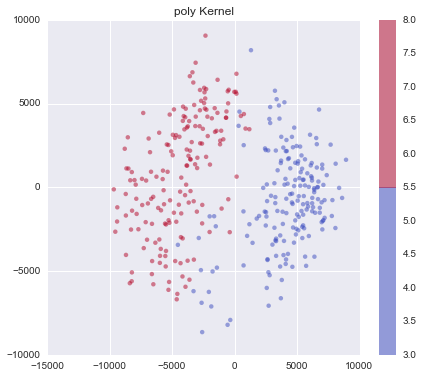

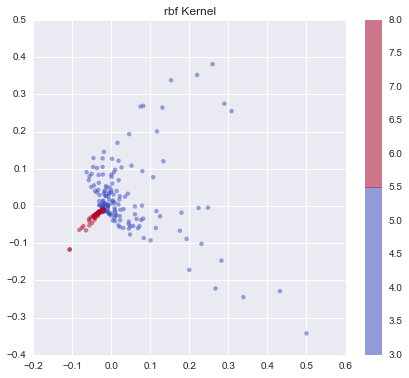

In [24]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

selector = np.logical_or(digits.target==3, digits.target==8)
X = digits.data[selector]
y = digits.target[selector]

def fisher(x,y):
    m1 = np.mean(x[y==3,0:2],axis=0)  
    m2 = np.mean(x[y==8,0:2],axis=0) 
    s1sq = np.sum(np.var(x[y==3,0:2],axis=0))
    s2sq = np.sum(np.var(x[y==8,0:2],axis=0))
    return np.dot(m1-m2,m1-m2)/(s1sq+s2sq)

for k in ["poly", "rbf"]:
    kpca = KernelPCA(kernel=k, degree=4, gamma=.009, coef0=120)
    Xproj = kpca.fit_transform(X)
    figure, ax = plt.subplots(figsize=(7,6))
    s = ax.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('coolwarm', 2))
    figure.colorbar(s, ax=ax)
    ax.set_title("%s Kernel" % k)
    
    print("%s fisher: %s" % (k, fisher(Xproj,y)))


### (b)

Poly fisher: 2.20562066407


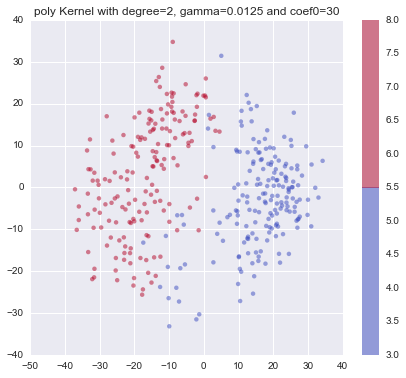

In [43]:
# Brute force search for highest F(w)
# May take a few minutes

highest = 0
params = None

for d in range(2,3):
    for g in np.arange(0.005,.03,.0005):
        for c in range(20,40,1):
            kpca = KernelPCA(kernel="poly", degree=d, gamma=g, coef0=c)
            Xproj = kpca.fit_transform(X)
            f = fisher(Xproj,y)
            if f > highest:
                highest = f
                params = (d,g,c)

# Plot the results from the best parameters
kpca = KernelPCA(kernel="poly", degree=params[0], gamma=params[1], coef0=params[2])
Xproj = kpca.fit_transform(X)

figure, ax = plt.subplots(figsize=(7,6))
s = ax.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
figure.colorbar(s, ax=ax)
ax.set_title("poly Kernel with degree=%s, gamma=%s and coef0=%s" % (params[0], params[1], params[2]))

print("Poly fisher: %s" % (fisher(Xproj,y)))

# Problem 2 (25%)

In this problem you'll use Sparse PCA on a (subset of a) publicly available community-level dataset with a large-ish number of real-valued features related to socioeconomic and crime statistics. See here for more details on the dataset:
<a href=http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime>$\texttt{http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime}$</a>

Use the SparsePCA module from sklearn to do Sparse PCA on the dataset. Notice that the alpha parameter controls the amount of sparsity. First choose a very large value of alpha. You should find that the identified principal components are all trivial (i.e. all identically zero). As you lower alpha, the leading principal component will at some point become non-trivial. 

__(a)__ What is the first non-trivial feature identified as important by Sparse PCA? (This may depend on some of the choices you make, e.g. which underlying sklearn algorithm you use)

__(b)__ As you continue to lower alpha you should eventually get to a point where the two leading (sparse) principal components are both non-trivial. Plot the data projected onto the two leading (sparse) principal components. Color each datapoint according to the column "ViolentCrimesPerPop_binary." Do the same thing for regular PCA. Which projection (PCA or Sparse PCA) leads to better separation (as judged visually) between low crime and high crime communities; or are they about the same? 

__(c)__ Compare the features identified by PCA and Sparse PCA as important. Is there strong overlap between the two sets of features?

In [45]:
data = pd.read_csv('communities.csv')

#set up one feature to indicate whether a community has above or below average violent crime levels
data['ViolentCrimesPerPop_binary']=data['ViolentCrimesPerPop']>np.mean(data['ViolentCrimesPerPop'])                                                                    
data = data.astype(float)
values = data.values
print("features:\n",data.columns.values[0:25])
print("\nprediction target:",data.columns.values[25:27])

features:
 ['population' 'householdsize' 'racepctblack' 'racePctWhite' 'racePctAsian'
 'racePctHisp' 'agePct12t21' 'agePct12t29' 'agePct16t24' 'agePct65up'
 'numbUrban' 'pctUrban' 'medIncome' 'pctWWage' 'pctWFarmSelf' 'pctWInvInc'
 'pctWSocSec' 'pctWPubAsst' 'pctWRetire' 'medFamInc' 'perCapInc'
 'whitePerCap' 'blackPerCap' 'indianPerCap' 'AsianPerCap']

prediction target: ['ViolentCrimesPerPop' 'ViolentCrimesPerPop_binary']


### (a)

In [63]:
# Iterate values of alpha starting at 100 and going down
for a in range(100,0,-1):
    # Run sparse PCA
    spca = SparsePCA(n_components=2,alpha=a,verbose=False,method='lars')
    X_proj = spca.fit_transform(values[:,0:25])
    
    # If any features are nonzero, stop
    if spca.components_[0,:].any():
        print(data.columns[0:25][spca.components_[0,:]!=0.0])
        break

Index([u'racePctWhite'], dtype='object')


### (b)

Index([u'pctUrban', u'medIncome', u'pctWWage', u'pctWInvInc', u'medFamInc',
       u'perCapInc', u'whitePerCap', u'blackPerCap', u'AsianPerCap'],
      dtype='object')
Index([u'householdsize', u'racePctWhite', u'agePct12t21', u'agePct12t29',
       u'agePct16t24', u'agePct65up', u'pctWWage', u'pctWFarmSelf',
       u'pctWInvInc', u'pctWSocSec', u'pctWPubAsst', u'pctWRetire',
       u'AsianPerCap'],
      dtype='object')


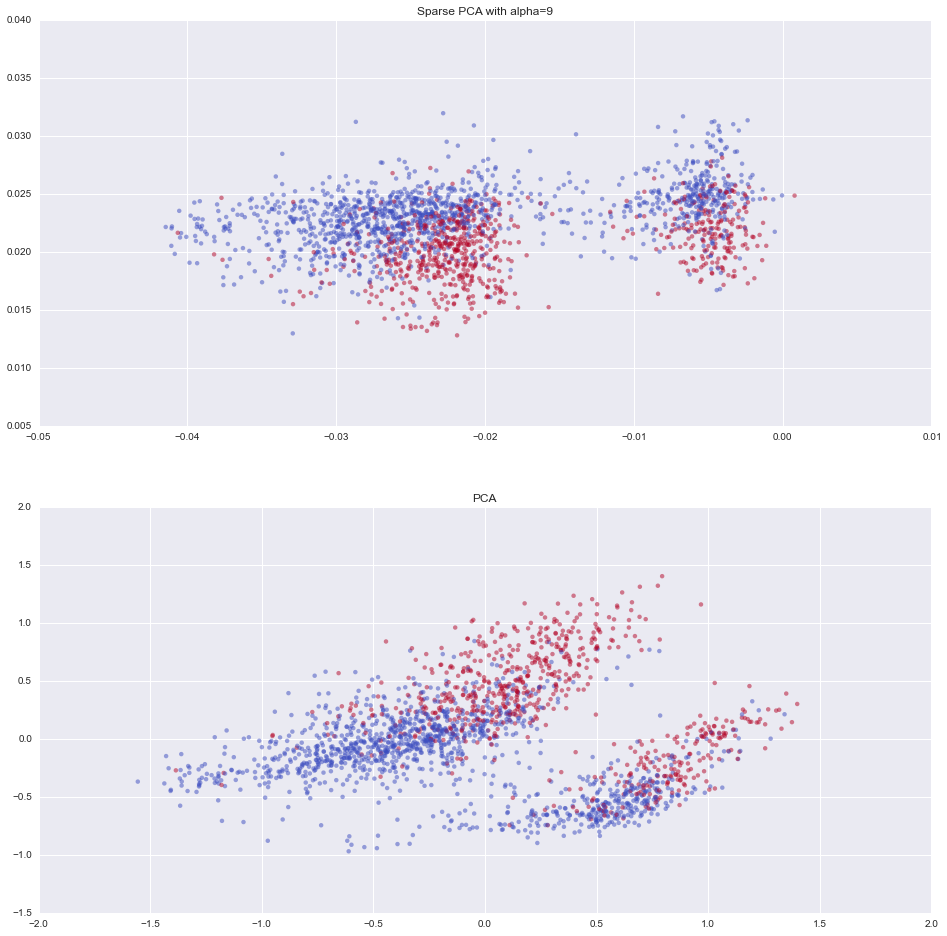

In [72]:
# Iterate values of alpha starting at 100 and going down
for a in range(100,0,-1):
    # Run sparse PCA
    spca = SparsePCA(n_components=2,alpha=a,verbose=False,method='lars')
    X_proj = spca.fit_transform(values[:,0:25])
    
    # When both of the first two princial components are non-trivial, stop
    if spca.components_[0,:].any() and spca.components_[1,:].any():
        print(data.columns[0:25][spca.components_[0,:]!=0.0])
        print(data.columns[0:25][spca.components_[1,:]!=0.0])
        break
        
# Setup Fig
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot spca
s = ax1.scatter(X_proj[:, 0], X_proj[:, 1], c=values[:,26], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
ax1.set_title('Sparse PCA with alpha=%s' % a)


# Run and plot PCA
pca = PCA(n_components=2)
X_proj = pca.fit_transform(values[:,0:25])
ax2.scatter(X_proj[:, 0], X_proj[:, 1], c=values[:,26], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
ax2.set_title('PCA')

PCA seems to do a somewhat better job of separating the two groups than SPCA

### (c)

In [85]:
df = pd.DataFrame([
    spca.components_[0,:],
    spca.components_[1,:],
    pca.components_[0,:],
    pca.components_[1,:],
], columns=data.columns[0:25], index=['Sparse PCA 1', 'Sparse PCA 2', 'PCA 1', 'PCA 2']).transpose()

# Adjust values to similar scale to compare
df = df/df.mean()
df['Diff 1'] = df['Sparse PCA 1'] - df['PCA 1']
df['Diff 2'] = df['Sparse PCA 2'] - df['PCA 2']

df

,Sparse PCA 1,Sparse PCA 2,PCA 1,PCA 2,Diff 1,Diff 2
population,-0.000000,0.000000,0.030114,5.262993,-0.030114,-5.262993
householdsize,-0.000000,2.197071,-0.087291,3.318597,0.087291,-1.121526
racepctblack,-0.000000,0.000000,-2.370895,11.978232,2.370895,-11.978232
racePctWhite,-0.000000,4.834461,2.185840,-15.843020,-2.185840,20.677481
racePctAsian,-0.000000,0.000000,1.859501,5.677455,-1.859501,-5.677455
racePctHisp,-0.000000,0.000000,-1.128537,9.073658,1.128537,-9.073658
agePct12t21,-0.000000,1.907681,-1.520524,2.085287,1.520524,-0.177606
agePct12t29,-0.000000,2.460885,-1.180940,4.330728,1.180940,-1.869842
agePct16t24,-0.000000,1.167829,-1.358304,3.107987,1.358304,-1.940158
agePct65up,-0.000000,1.894301,-0.834961,-4.199591,0.834961,6.093892


The two methods seem to largely agree about the features in the first principal component.  The only noticable difference is PCA puts some weight to `pctWPubAsst` where SPCA doesn't.

The second principal component differs much more, especially in `racePctWhite` and `pctUrban`.

# Problem 3 (10%)
Suppose I have a $D-$dimensional dataset that I want to dimensionally reduce to $d<D$ dimensions using PCA.

__(a)__ Will the result be any different if I first rotate the data (i.e. with an arbitrary orthogonal or rotation matrix)? Why or why not?

__(b)__ Will the result be any different if I first apply an arbitrary linear transformation to the data? Why or why not?

__(c)__ Will the result be any different if I first offset the data by some fixed vector (i.e. translate the data by some fixed amount)? Why or why not?

__(a)__

__(b)__

# Problem 4 (10%)
Suppose we are given a large dataset distributed according to a $D$-dimensional normal distribution with zero mean and diagonal covariance matrix ($\Sigma = \sigma^2 \mathbb{1_{\rm{D}}}$ with $\sigma \in \mathbb{R}$, $\sigma>0$). Suppose we use PCA on the dataset to do dimensional reduction down to $d<D$ dimensions. 

__(a)__ What approximate fraction of the variance do you expect to be preserved by the mapping induced by PCA ($\mathbb{R}^D \to \mathbb{R}^d$)?

__(b)__ Does this fraction depend on the specific value of $\sigma$? If so how?

# Problem 5 (10%)
Suppose that we a given a very high-dimensional dataset. Suppose furthermore that any given datapoint $\bf x_i$ is very sparse, i.e. most of the features are zero. Suppose further that the $\{ \bf x_i \}$ are all fixed to have unit length. Do you expect PCA to be of much use for dimensional reduction in this scenario? Why or why not? _Hint_: you might consider creating fake data and running PCA on it.

# Problem 6 (10%)
Consider the four datasets plotted below (A, B, C, D) where each datapoint has an x-coordinate, a y-coordinate, and a binary indicator $z$ (0 or 1). Imagine doing PCA on these four datasets. After doing dimensional reduction down from 2 dimensions to 1, which dataset will exhibit the best separation between $z=0$ and $z=1$? You should be able to answer this question without any kind of calculations, but if you prefer, do the PCA explicitly and then give a well-reasoned argument that explains what you found.

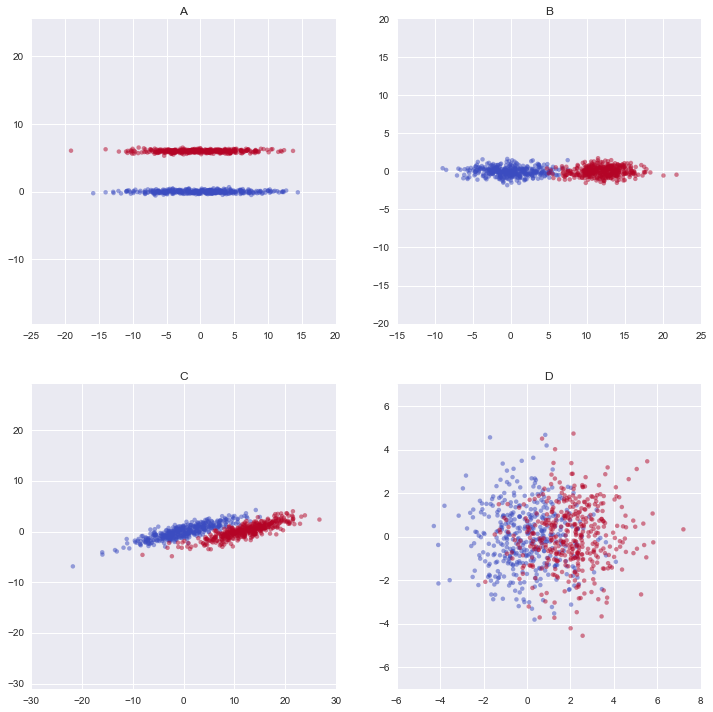

In [37]:
def get_dataset(a,b,c,d,x,y):
  XY1 = np.dot(np.array([[a,b],[c,d]]), np.random.normal(size=(2, 400))).T
  Z1 = np.ones(400)*0
  XY2 = [x,y]+np.dot(np.array([[a,b],[c,d]]), np.random.normal(size=(2, 400))).T
  Z2 = np.ones(400)*1
  XY=np.concatenate([XY1,XY2])  
  Z=np.concatenate([Z1,Z2])  
  return [XY,Z]

fig, ((axA, axB), (axC, axD)) = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

[XY_A, Z_A] = get_dataset(5,0,0,.2,0,6)
[XY_B, Z_B] = get_dataset(2,2,.4,-.4,12,0)
[XY_C, Z_C] = get_dataset(5,1,1,1,12,0)
[XY_D, Z_D] = get_dataset(1,1,-1,1,2,0)

axA.scatter(XY_A[:, 0], XY_A[:, 1], c=Z_A, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axA.set_title('A')
axB.scatter(XY_B[:, 0], XY_B[:, 1], c=Z_B, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axB.set_title('B')
axC.scatter(XY_C[:, 0], XY_C[:, 1], c=Z_C, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axC.set_title('C')
axD.scatter(XY_D[:, 0], XY_D[:, 1], c=Z_D, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2));
axD.set_title('D');
axA.axis('equal'); axB.axis('equal'); axC.axis('equal'); axD.axis('equal');

# Extra credit problem  (25%)
Create an artificial dataset in two dimensions where each datapoint, in addition to having xy-coordinates, also has a binary indicator $z$, with $z=0$ or $z=1$. Consider doing Kernel PCA on the real coordinates ($D=2$ & $d=2$) and observing how well the Kernel PCA helps separate the datapoints with respect to the binary indicator $z$. The dataset you create should have the following properties:

- i) it _cannot_ be well separated using Kernel PCA with a low-dimensional polynomial kernel
- ii) it _can_ be well separated using Kernel PCA with a rbf kernel

Explain the properties of your dataset that make it satisfy i) and ii) and explicitly plot the results of using polynomial and rbf kernels on the dataset you've created so as to demonstrate i) and ii).

### partial solution

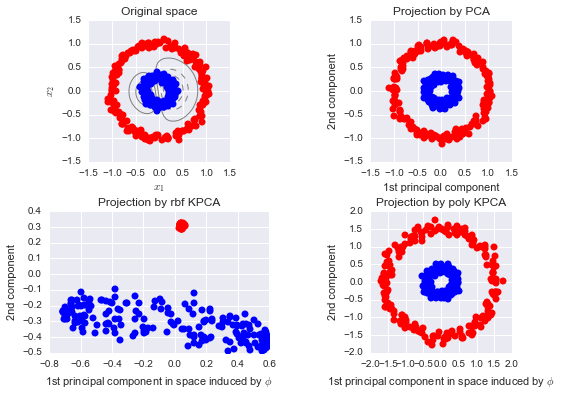

In [38]:
from sklearn.datasets import make_circles
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)
kpca2 = KernelPCA(kernel="poly", degree=4)#, gamma=1, coef0=1)
X_kpca2 = kpca2.fit_transform(X)
X_pca = pca.fit_transform(X)

# Plot results

plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.plot(X[reds, 0], X[reds, 1], "ro")
plt.plot(X[blues, 0], X[blues, 1], "bo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

X1, X2 = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# projection on the first principal component (in the phi space)
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.plot(X_pca[reds, 0], X_pca[reds, 1], "ro")
plt.plot(X_pca[blues, 0], X_pca[blues, 1], "bo")
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.plot(X_kpca[reds, 0], X_kpca[reds, 1], "ro")
plt.plot(X_kpca[blues, 0], X_kpca[blues, 1], "bo")
plt.title("Projection by rbf KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.plot(X_kpca2[reds, 0], X_kpca2[reds, 1], "ro")
plt.plot(X_kpca2[blues, 0], X_kpca2[blues, 1], "bo")
plt.title("Projection by poly KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()